# Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# load config
with open('../config/params.yaml', 'r') as f:
    config = yaml.safe_load(f)

# load processed data
df = pd.read_csv('../' + config['data']['processed_path'], index_col='time', parse_dates=True)

# Visualizing Price vs "Cheapness" (Z-Score)

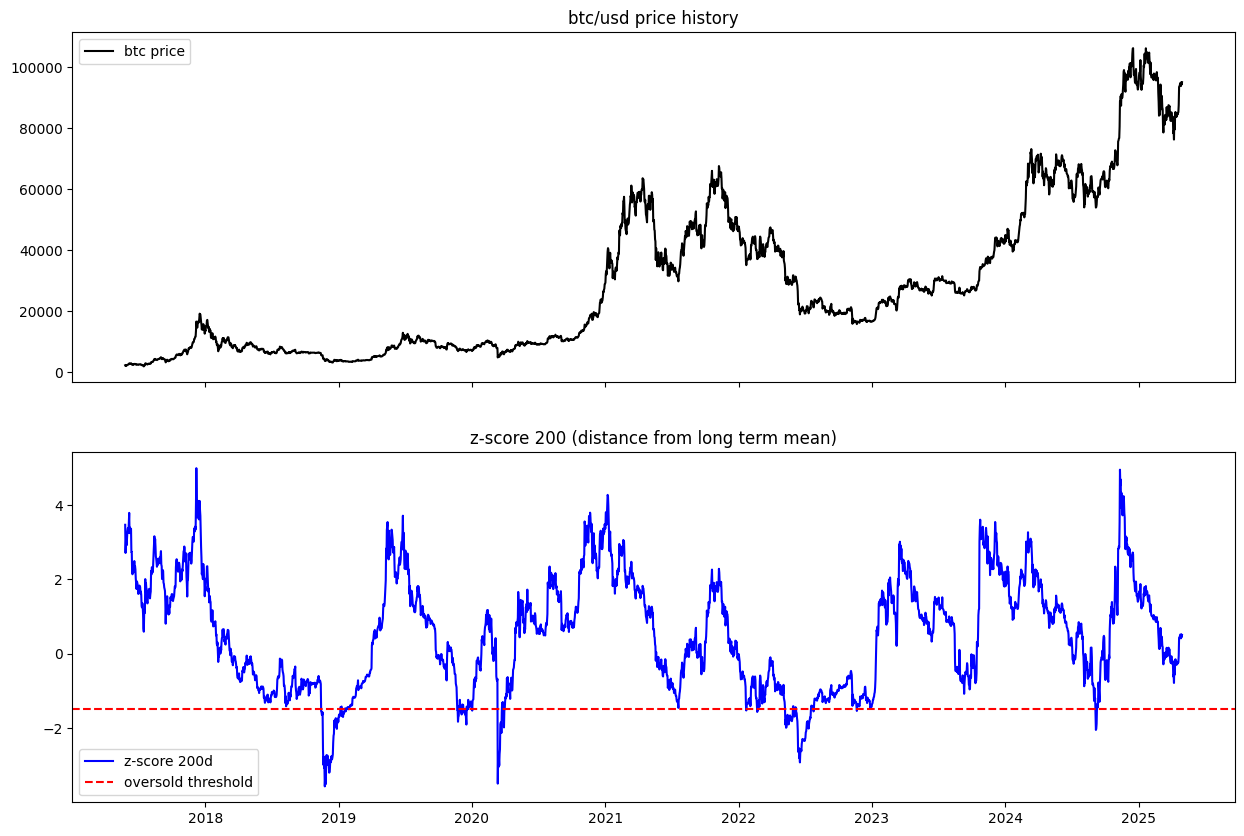

In [2]:
# plot price and z-score to identify buy zones
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

ax1.plot(df['close'], label='btc price', color='black')
ax1.set_title('btc/usd price history')
ax1.legend()

ax2.plot(df['z_score_200'], label='z-score 200d', color='blue')
ax2.axhline(y=-1.5, color='red', linestyle='--', label='oversold threshold')
ax2.set_title('z-score 200 (distance from long term mean)')
ax2.legend()

plt.show()

# "Smoking Gun" (Z-Score vs Label)

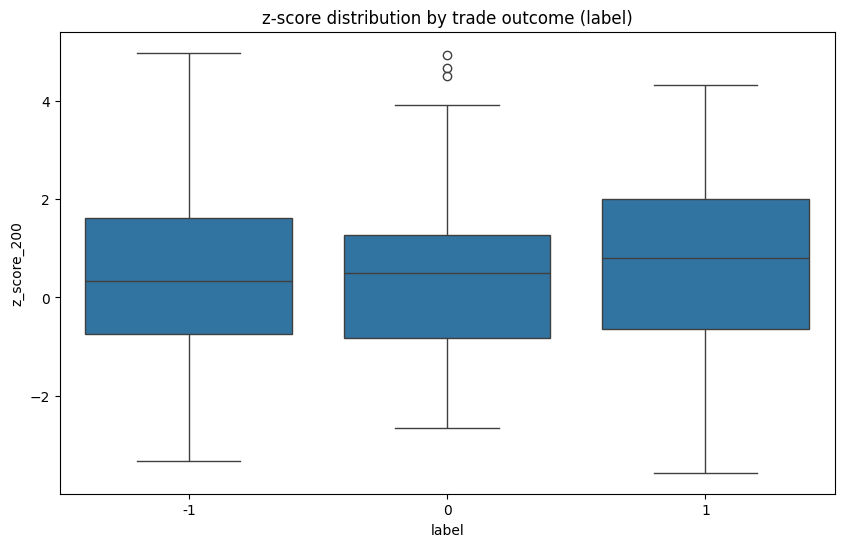

In [3]:
# boxplot: does a lower z-score lead to more profit labels (1)?
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='z_score_200', data=df)
plt.title('z-score distribution by trade outcome (label)')
plt.show()

# Feature correlation Heatmap
It's needed to know if our features are redundant. If two variables have a correlation of 0.95, the ML model will not learn anything new from the second one, and this can cause overfitting.

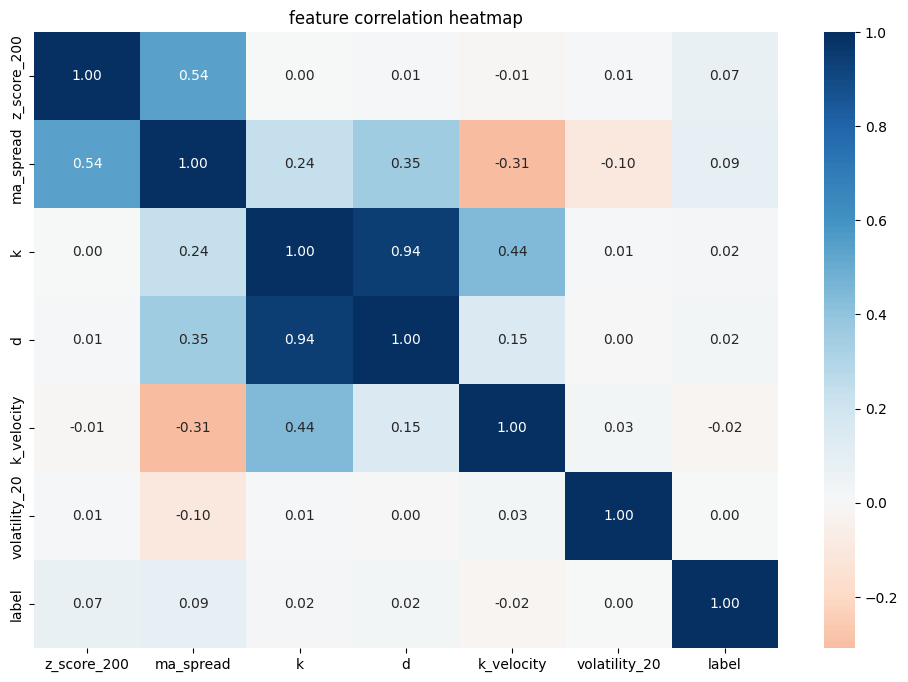

In [4]:
# correlation matrix to check for redundancy
plt.figure(figsize=(12, 8))
# we only care about technical features and the label
features_to_check = ['z_score_200', 'ma_spread', 'k', 'd', 'k_velocity', 'volatility_20', 'label']
corr = df[features_to_check].corr()

sns.heatmap(corr, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('feature correlation heatmap')
plt.show()

# Augmented Dickey-Fuller (ADF) Test

In quantitative trading, predicting raw prices is impossible because they are not stationary (the mean and variance change over time). It's needed our features to be stationary for the ML model to be robust.


In [5]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"- - -  adf test for: {name}  - - -")
    print(f"adf statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("result: stationary (good for ml)")
    else:
        print("result: non-stationary (needs transformation)")
    print("-" * 30)

# testing our main features
check_stationarity(df['z_score_200'], 'z_score_200')
check_stationarity(df['ma_spread'], 'ma_spread')
check_stationarity(df['k'], 'stochastic_k')

- - -  adf test for: z_score_200  - - -
adf statistic: -4.0397
p-value: 0.0012
result: stationary (good for ml)
------------------------------
- - -  adf test for: ma_spread  - - -
adf statistic: -7.6508
p-value: 0.0000
result: stationary (good for ml)
------------------------------
- - -  adf test for: stochastic_k  - - -
adf statistic: -10.6506
p-value: 0.0000
result: stationary (good for ml)
------------------------------
